In [1]:
import warnings
import re
from PIL import Image
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument



/Users/nguyenminhdan/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
warnings.filterwarnings('ignore')

In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

In [4]:
# display options for pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
# pd.reset_option('display.max_colwidth')

In [5]:
# check directory with movielens data files
# https://grouplens.org/datasets/movielens/
! ls -lh imovie_data

total 163472
-rw-r--r--@ 1 nguyenminhdan  staff   919K May  1 11:37 data_movie.csv
-rw-r--r--  1 nguyenminhdan  staff    22K Apr 30 17:02 data_movie_link.csv
-rw-r--r--@ 1 nguyenminhdan  staff   3.3M Apr 30 15:16 data_movie_version1.csv
-rw-r--r--@ 1 nguyenminhdan  staff    18K Sep 27  2018 genome-tags.csv
-rw-r--r--@ 1 nguyenminhdan  staff    44M Apr 30 17:29 genome_scores_data.csv
-rw-r--r--@ 1 nguyenminhdan  staff    29K Apr 30 17:54 movie_youtube.csv
-rw-r--r--@ 1 nguyenminhdan  staff    32M Apr 25 19:04 tags.csv


In [6]:
# quickly check out data
! head -10 imovie_data/data_movie.csv

"movieid","title","year","length","genres","rate","poster","plot","trailer","movielenid","youtubeid"
"tt1038988","[Rec]","2007","78","Horror","7.4","https://m.media-amazon.com/images/M/MV5BZTJmNTZlZWUtZTQ2Yi00YTFjLWFiNzctYzFlNmZmZGMzYTlmXkEyXkFqcGdeQXVyMjQ2MTk1OTE@._V1_.jpg","A television reporter and cameraman follow emergency workers into a dark apartment building and are quickly locked inside with something terrifying.","https://imdb-video.media-imdb.com/vi1419903513/1434659607842-pgv4ql-1564097131787.mp4?Expires=1585982051&Signature=mcvP17lX~OOQ~lwZ3qq7Yn1v3xBFeH0NPp17mXeHnk~VJoqFwxakjNd6e6OAh18Oc9qBSuA5kLL0vzBpq8Px9C~mcKVlzi2zrbiyeVdjNkyTddiML4k7t-BCcaxte0VDtKzEQDN37XE6XA5JDIJNcPPJ7EtDnzUtjQRs6eQNOHC2M3mOfWpjmE4HU5ukdyvy7S-GZAR8iHKqZ1Vc22jWi0EI8Na8ju9zefyQC5LCg1L01nvIuoxXq2X9fJ8DYA80MeGyB4RBxuU8h9BfLB9IHMTVSWVgq56v1wnyleYt2JPXUA89Q4nZMGYmnwFokZFOK-W5GhI8gU3obP8vDmC3AA__&Key-Pair-Id=APKAIFLZBVQZ24NQH3KA","57274","YQUkX_XowqI"
"tt1060277","Cloverfield","2008","85","Action|Adventure|

In [7]:
# quickly check out data
! head -10 imovie_data/genome_scores_data.csv

movieId,tagId,relevance,movieID:1
55069,1,0.02150000000000002,tt1032846
55069,2,0.020000000000000018,tt1032846
55069,3,0.04049999999999998,tt1032846
55069,4,0.05425000000000002,tt1032846
55069,5,0.05275000000000002,tt1032846
55069,6,0.09050000000000002,tt1032846
55069,7,0.05425000000000002,tt1032846
55069,8,0.1285,tt1032846
55069,9,0.34924999999999995,tt1032846


In [8]:
# quickly check out data
! head -10 imovie_data/genome-tags.csv

In [9]:
# movie titles
mv_genres = pd.read_csv('imovie_data/data_movie.csv')

In [10]:
# movie tags
mv_tags = pd.read_csv('imovie_data/genome_scores_data.csv')

In [11]:
# movie tag descriptions
mv_tags_desc = pd.read_csv('imovie_data/genome-tags.csv')

In [13]:
movie = {}
movie = pd.DataFrame(data=movie)

movie['imdbId'] = mv_genres['movieid']
movie['movieId'] = mv_genres['movielenid']



In [15]:
movie.head()

,imdbId,movieId
0,tt1038988,57274
1,tt1060277,57368
2,tt1073498,57532
3,tt1023481,58107
4,tt1001562,58146


# Q1: How many tags do we need or each movie?

In [16]:
# number of tags
len(np.unique(mv_tags_desc.tagId.values))

1128

In [17]:
# number of movies
len(np.unique(mv_tags.movieId.values))

1073

In [18]:
# number of movie, tag pairs
len(mv_tags)

1210344

In [19]:
# join dataframes to get tag description and movie title name all in one table
mv_tags_denorm = mv_tags.merge(mv_tags_desc, on = 'tagId').merge(movie, on = 'movieId')

# for each movie, compute the relevance rank of tags so we can eventually rank order tags for each movie
mv_tags_denorm['relevance_rank'] = mv_tags_denorm.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')



In [21]:
# check out an example of top tags for a movie
mv_tags_denorm[mv_tags_denorm.imdbId == 'tt1099212'][['movieId','imdbId','tag','relevance','relevance_rank']].sort_values(by = 'relevance', ascending = False).head(10)

,movieId,imdbId,tag,relevance,relevance_rank
40547,63992,tt1099212,vampire human love,1.00000,1
40548,63992,tt1099212,vampires,0.99750,2
39586,63992,tt1099212,based on a book,0.99425,3
39501,63992,tt1099212,adapted from:book,0.99225,4
40546,63992,tt1099212,vampire,0.98975,5
40585,63992,tt1099212,werewolves,0.96850,6
40492,63992,tt1099212,teen,0.96600,8
39632,63992,tt1099212,book was better,0.96600,7
39592,63992,tt1099212,based on book,0.96150,9
40493,63992,tt1099212,teen movie,0.95750,10


In [22]:
# compute median relevance score for each relevance rank
mv_tags_rank_agg = mv_tags_denorm.groupby('relevance_rank')['relevance'].median().reset_index(name = 'relevance_median').head(100)

# compute percent change of median relevance score as we go down in rank
mv_tags_rank_agg['relevance_median_pct_chg'] = mv_tags_rank_agg['relevance_median'].pct_change()

Text(0.5, 1.0, 'Box Plot:  Tag Relevance Score by Rank ')

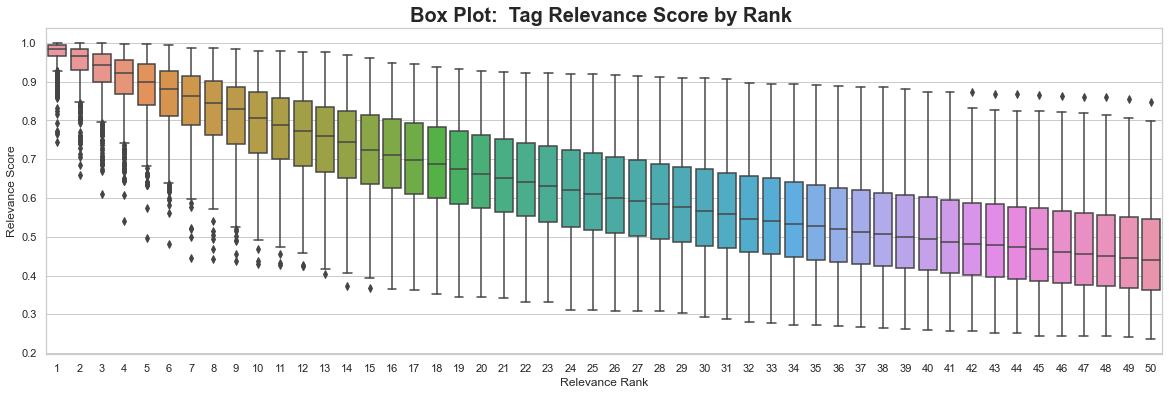

In [23]:
# print(mv_tags_denorm[mv_tags_denorm.relevance_rank < 3])
# Ở đây là lấy tất cả các cái tag của tất cả các cái rank ... ví dụ phim A lấy 3 rank cao nhất rồi tính điểm trung bình 
# liên quan với nó 
# Nhận ra một điều rằng vơí các cái tag có thứ hạng cang cao thì trung vị của nó càng cao ... rank 1 > mức độ liên quan 
# lớn hơn rank 2 nha 
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(20, 6))

ax = sns.boxplot(x = "relevance_rank", y = "relevance", data = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 50], showfliers = True)
ax.set(ylabel = "Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("Box Plot:  Tag Relevance Score by Rank ", fontsize = 20, weight = 'bold')

Text(0.5, 1.0, '% Change in Tag Relevance Score by Rank')

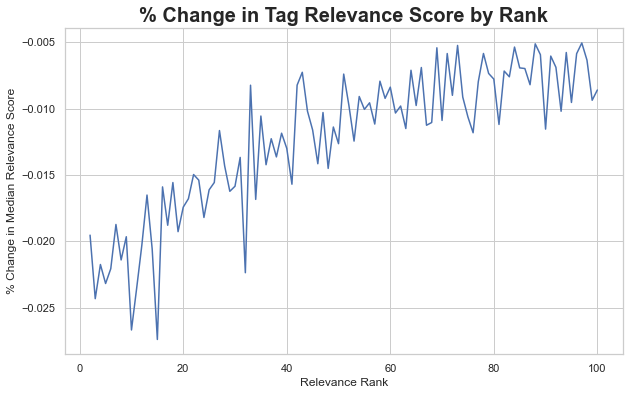

In [24]:
# elbow method -- heritics in AI ==> Lay so luong tag phu hop

f, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(x="relevance_rank", y="relevance_median_pct_chg", data = mv_tags_rank_agg)
ax.set(ylabel = "% Change in Median Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("% Change in Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')

# Bay gio thi nen chon bao nhieu cai de tinh rank day ???
# Neu lay it thi se bi mot truong hop la it tag , ma neu lay nhieu tag thi se bi lay tag khong lien quan  =>>
# Hien tai data hoi xau nen chua can quan tam lam den cai nay 
 # Chi can nho la phai hoc elbow method no la mot cai heritics trong AI

In [26]:
# flatten tags table to get a list of top 100 tags for each movie
mv_tags_list = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 100].groupby(['movieId','imdbId'])['tag'].apply(lambda x: ','.join(x)).reset_index()
mv_tags_list['tag_list'] = mv_tags_list.tag.map(lambda x: x.split(','))

In [27]:
mv_tags_list.head(1)

,movieId,imdbId,tag,tag_list
0,57274,tt1038988,"adaptation,apocalypse,atmospheric,better than expected,better than the american version,biting,bleak,blood,bloody,brutality,catastrophe,chase,claustrophobic,clever,creativity,creepy,cult classic,dark,dark humor,demons,dialogue,disturbing,drinking,eerie,forceful,foreign,frightening,good,good acting,good soundtrack,goretastic,gory,great,great acting,great ending,great movie,grim,grindhouse,gruesome,handycam,haunted house,honest,horror,hospital,imdb top 250,intense,interesting,isolation,latin america,life philosophy,light,low budget,macabre,mentor,monster,movielens top pick,nocturnal,not funny,ominous,original,original plot,paranoid,pg-13,police,pornography,psychological,realistic,revenge,runaway,scary,sexualized violence,so bad it's funny,social commentary,solitude,spain,spanish,splatter,stereotypes,story,storytelling,stylized,supernatural,survival,suspense,suspenseful,talky,tense,thriller,transformation,twist,violence,violent,virus,visceral,weapons,weird,witch,witches,zombie,zombies","[adaptation, apocalypse, atmospheric, better than expected, better than the american version, biting, bleak, blood, bloody, brutality, catastrophe, chase, claustrophobic, clever, creativity, creepy, cult classic, dark, dark humor, demons, dialogue, disturbing, drinking, eerie, forceful, foreign, frightening, good, good acting, good soundtrack, goretastic, gory, great, great acting, great ending, great movie, grim, grindhouse, gruesome, handycam, haunted house, honest, horror, hospital, imdb top 250, intense, interesting, isolation, latin america, life philosophy, light, low budget, macabre, mentor, monster, movielens top pick, nocturnal, not funny, ominous, original, original plot, paranoid, pg-13, police, pornography, psychological, realistic, revenge, runaway, scary, sexualized violence, so bad it's funny, social commentary, solitude, spain, spanish, splatter, stereotypes, story, storytelling, stylized, supernatural, survival, suspense, suspenseful, talky, tense, thriller, transformation, twist, violence, violent, virus, visceral, weapons, weird, witch, witches, zombie, zombies]"


In [30]:
pd.set_option('display.max_colwidth', -1)
# MOVIE - Twilight
mv_tags_list.loc[mv_tags_list.imdbId == 'tt1038988', ['movieId','imdbId','tag_list']]

,movieId,imdbId,tag_list
0,57274,tt1038988,"[adaptation, apocalypse, atmospheric, better than expected, better than the american version, biting, bleak, blood, bloody, brutality, catastrophe, chase, claustrophobic, clever, creativity, creepy, cult classic, dark, dark humor, demons, dialogue, disturbing, drinking, eerie, forceful, foreign, frightening, good, good acting, good soundtrack, goretastic, gory, great, great acting, great ending, great movie, grim, grindhouse, gruesome, handycam, haunted house, honest, horror, hospital, imdb top 250, intense, interesting, isolation, latin america, life philosophy, light, low budget, macabre, mentor, monster, movielens top pick, nocturnal, not funny, ominous, original, original plot, paranoid, pg-13, police, pornography, psychological, realistic, revenge, runaway, scary, sexualized violence, so bad it's funny, social commentary, solitude, spain, spanish, splatter, stereotypes, story, storytelling, stylized, supernatural, survival, suspense, suspenseful, talky, tense, thriller, transformation, twist, violence, violent, virus, visceral, weapons, weird, witch, witches, zombie, zombies]"


# Q2: How do we use tags to measure the similarity between movies?

In [32]:
# compute Jaccard Index to get most similar movies to target movie

pd.reset_option('display.max_colwidth')

target_movie_id = 'tt1038988'

target_tag_list = mv_tags_list[mv_tags_list.imdbId == target_movie_id].tag_list.values[0]
mv_tags_list_sim = mv_tags_list[['movieId','imdbId','tag_list','tag']]
mv_tags_list_sim['jaccard_sim'] = mv_tags_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))
print(f'Movies most similar to {target_movie_id} based on tags:')
text = ','.join(mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(25)['tag'].values)
#print(text)#
# mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(7)

recommend_movie = mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(7)['imdbId']

recommend_movie = recommend_movie[1:]

# recommend_movie = mv_tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(7)['imdbId']

print(recommend_movie)

Movies most similar to tt1038988 based on tags:
655    tt1457767
815    tt2870612
303    tt1591095
163    tt1245112
79     tt1148204
547    tt1922777
Name: imdbId, dtype: object


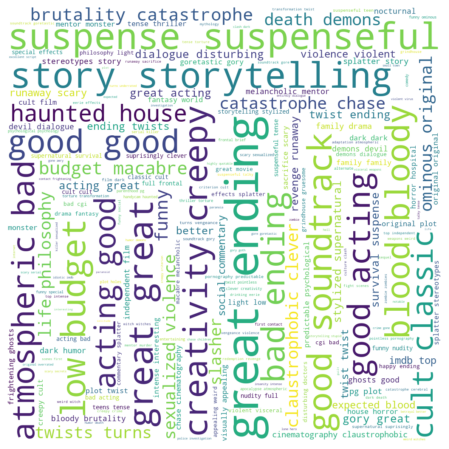

In [33]:
plt.rcParams["figure.figsize"] = (15,10)

# Generate a word cloud image
wordcloud = WordCloud(width = 1024, height = 1024, background_color = 'white').generate(text)

# Display the generated image:
plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Cosine similarity

In [34]:
# corpus of movie tags
mv_tags_corpus = mv_tags_list.tag.values

In [35]:
import nltk 
#nltk.download('stopwords')


from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [36]:
stop_words = stopwords.words('english')

# tokenize document and clean
def word_tokenize_clean(doc):
  
  # split into lower case word tokens
  tokens = word_tokenize(doc.lower())
  
  # remove tokens that are not alphabetic (including punctuation) and not a stop word
  tokens = [word for word in tokens if word.isalpha() and not word in stop_words]
  
  return tokens

In [37]:
# import nltk
#nltk.download('punkt')

In [38]:
# preprocess corpus of movie tags before feeding it into Doc2Vec model
mv_tags_doc = [TaggedDocument(words=word_tokenize_clean(D), tags=[str(i)]) for i, D in enumerate(mv_tags_corpus)]

In [39]:
# instantiate Doc2Vec model

max_epochs = 50
vec_size = 20
alpha = 0.025

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=0) # paragraph vector distributed bag-of-words (PV-DBOW)
  
model.build_vocab(mv_tags_doc)

In [40]:
# train Doc2Vec model
# stochastic (random initialization), so each run will be different unless you specify seed

print('Epoch', end = ': ')
for epoch in range(max_epochs):
  print(epoch, end = ' ')
  model.train(mv_tags_doc,
              total_examples=model.corpus_count,
              epochs=model.epochs)
  # decrease the learning rate
  model.alpha -= 0.0002
  # fix the learning rate, no decay
  model.min_alpha = model.alpha

model.save('model_version3')

Epoch: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

In [41]:
# listing space embeddings
model3 = Doc2Vec.load('model_version3')
mv_tags_vectors = model3.dv.vectors 

In [42]:
mv_tags_vectors.shape

(902, 20)

In [47]:
# top similar movies based on cosine similarity

mv = 'tt1038988' # Twilight movie

mv_index = mv_tags_list[mv_tags_list["imdbId"] == mv].index.values[0]
print('vector movie:')
print(mv_tags_vectors[mv_index])
print ('list movie similarity:')
sims = model.docvecs.most_similar(positive = [mv_index], topn = 30)

for i, j in sims:
  print(mv_tags_list.loc[int(i), "imdbId"].strip())

vector movie:
[ 0.35257876  0.44949153  0.08400433  2.1166437   0.50737774 -0.4703496
  0.8231916  -1.2419473   0.04453918  0.01736774 -1.9622884  -0.60552406
  1.1050502  -0.26754156 -0.29129475 -0.73461044  0.3680698   0.45947102
 -1.2595717   0.9643149 ]
list movie similarity:
tt3504048
tt1082868
tt1179904
tt1172994
tt1278340
tt1020530
tt1536044
tt2473682
tt2752758
tt1778304
tt2034139
tt1748227
tt2109184
tt1457767
tt1245112
tt2870612
tt1594562
tt1740707
tt1148204
tt2023587
tt1437358
tt3099498
tt1259521
tt1124052
tt1127180
tt3235888
tt1991245
tt1623288
tt1610996
tt2103217


In [48]:
import umap.umap_ as umap


# dimensionality reduction to 2D
mv_tags_vectors_umap = umap.UMAP(n_neighbors = 5,
                          min_dist = 0.001,
                          metric = 'cosine').fit_transform(mv_tags_vectors)

In [49]:
x, y = mv_tags_vectors_umap.T[0], mv_tags_vectors_umap.T[1]

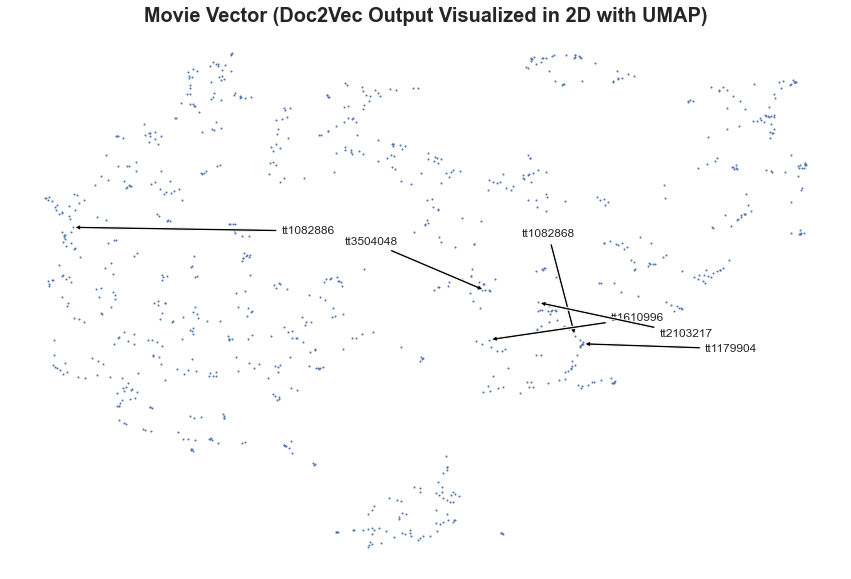

In [51]:
# visualize movie vectors in 2D with UMAP
# label some movies

plt.rcParams["figure.figsize"] = (15,10)
plt.grid(b = None)
plt.axis('off')
plt.scatter(x, y, s = 1)
plt.title('Document Embedding (UMAP)')
plt.xlabel('e1')
plt.ylabel('e2')

mv = 'tt3504048'
mv_index = mv_tags_list[mv_tags_list["imdbId"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]-1, mv_tags_vectors_umap[mv_index, 1]+1),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'tt1082868'
mv_index = mv_tags_list[mv_tags_list["imdbId"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]+2),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'tt1179904'
mv_index = mv_tags_list[mv_tags_list["imdbId"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'tt1610996'
mv_index = mv_tags_list[mv_tags_list["imdbId"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]+0.5),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'tt2103217'
mv_index = mv_tags_list[mv_tags_list["imdbId"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+2, mv_tags_vectors_umap[mv_index, 1]-0.5),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

mv = 'tt1082886'
mv_index = mv_tags_list[mv_tags_list["imdbId"] == mv].index.values[0]  
plt.annotate(mv, 
             xy=(mv_tags_vectors_umap[mv_index, 0], mv_tags_vectors_umap[mv_index, 1]),
             xytext=(mv_tags_vectors_umap[mv_index, 0]+3, mv_tags_vectors_umap[mv_index, 1]+0.025),
             xycoords='data',
             arrowprops=dict(facecolor='black', arrowstyle = 'simple'),
             horizontalalignment='right', verticalalignment='top',
            )

plt.title('Movie Vector (Doc2Vec Output Visualized in 2D with UMAP)', fontsize = 20, weight = 'bold')
plt.show()

# Q3: How do we use tags to generate movie recommendations for a user?

In [53]:
# history of movies the user watched and liked
user_movies = ['tt3504048', 'tt1082868', 'tt1179904', 'tt1610996', 'tt2103217', 'tt1082886']

# compute user vector as an average of movie vectors seen by that user
user_movie_vector = np.zeros(shape = mv_tags_vectors.shape[1])
for mv in user_movies:
  mv_index = mv_tags_list[mv_tags_list["imdbId"] == mv].index.values[0]  
  user_movie_vector += mv_tags_vectors[mv_index]

user_movie_vector /= len(user_movies)  

# print(user_movie_vector)
  
#  find movies similar to user vector to generate movie recommendations

print('Movie Recommendations:')

sims = model.docvecs.most_similar(positive = [user_movie_vector], topn = 30)

for i, j in sims:
  movie_sim = mv_tags_list.loc[int(i), "imdbId"].strip()
  if movie_sim not in user_movies:
    print(movie_sim)

Movie Recommendations:
tt1172994
tt1038988
tt2034139
tt1536044
tt1594562
tt1778304
tt1748227
tt1020530
tt2473682
tt3322940
tt1127180
tt3235888
tt1288558
tt1991245
tt1731697
tt2109184
tt1591095
tt2023587
tt2752758
tt1320244
tt1226681
tt1703199
tt1085779
tt1245112
tt1437358
